In [1]:
%matplotlib inline
import os
import sys
import lenspyx
from lenspyx.utils import camb_clfile
import matplotlib.pyplot as pl
import healpy as hp, numpy as np
import pickle as pk

In [2]:
sys.path.append('../')
from helper import clhash,hash_check #helper fuction for hashing a given Cls(multipoles)
import mpi

In [3]:
lmax = 4096
nside = 2048

In [4]:
path = "Sims/CAMB/"
lens_file =  "BBSims_lensed_dls.dat"
pot_file = "BBSims_lenspotential.dat"

In [5]:
class CMBLensed:
    """
    Lensing class:
    It saves seeds, Phi Map and Lensed CMB maps
    
    """
    def __init__(self,outfolder,nsim,lmax,nside,cl_path,lens_file,pot_file,verbose=False):
        self.outfolder = outfolder
        self.cl_len = camb_clfile(os.path.join(cl_path, lens_file))
        self.cl_unl = camb_clfile(os.path.join(cl_path, pot_file))
        self.nside = nside
        self.lmax = lmax
        self.dlmax = 1024
        self.facres = 0
        self.verbose = verbose
        self.nsim = nsim
        
        if mpi.rank == 0:
            os.makedirs(self.outfolder,exist_ok=True)
            os.makedirs(os.path.join(self.outfolder,'Phi'),exist_ok=True) #folder for mass
            os.makedirs(os.path.join(self.outfolder,'CMB'),exist_ok=True) #folder for CMB
        
        self.seeds = [np.random.randint(11111,99999) for i in range(self.nsim)]
        fname = os.path.join(self.outfolder,'seeds.pkl')
        if (not os.path.isfile(fname)) and (mpi.rank == 0):
            pk.dump(self.seeds, open(fname,'wb'), protocol=2)
        else:
            self.seeds = pk.load(open(fname,'rb'))
        
        
        # Here I saves a dictonary with the artibutes of this class and given Cls. 
        # So everytime when this instance run it checks for the same setup
        # If any artribute has changed from the previous run
        fnhash = os.path.join(self.outfolder, "lensing_sim_hash.pk")
        if (mpi.rank == 0) and (not os.path.isfile(fnhash)):
            pk.dump(self.hashdict(), open(fnhash, 'wb'), protocol=2)
        mpi.barrier()
        
        hash_check(pk.load(open(fnhash, 'rb')), self.hashdict())

    def hashdict(self):
        return {'nside':self.nside,
                'lmax':self.lmax,
                'nsim':self.nsim,
                'cl_tt_un': clhash(self.cl_unl['tt']),
                'cl_tt_le': clhash(self.cl_len['tt']),
               }
         
    def vprint(self,string):
        if self.verbose:
            print(string)
                  
    def get_phi(self,idx):
        """
        set a seed
        generate phi_LM
        Save the phi
        """
        fname = os.path.join(self.outfolder,'Phi',f"phi_sims_{idx:04d}.fits")
        if os.path.isfile(fname):
            self.vprint(f"Phi field from cache: {idx}")
            return hp.read_alm(fname)
        else:
            np.random.seed(self.seeds[idx])
            plm = hp.synalm(self.cl_unl['pp'], lmax=self.lmax + self.dlmax, new=True)
            hp.write_alm(fname,plm)
            self.vprint(f"Phi field cached: {idx}")
            return plm
        
    def get_kappa(self,idx):
        """
        generate deflection field
        sqrt(L(L+1)) * \phi_{LM}
        """
        der = np.sqrt(np.arange(self.lmax + 1, dtype=float) * np.arange(1, self.lmax + 2))
        return hp.almxfl(self.get_phi(idx), der)
    
    def get_unlensed_tlm(self,idx):
        self.vprint(f"Synalm-ing the Unlensed CMB temp: {idx}")
        return hp.synalm(self.cl_unl['tt'],lmax=self.lmax + self.dlmax,new=True)

    def get_unlensed_elm(self,idx):
        self.vprint(f"Synalm-ing the Unlensed CMB pol-E: {idx}")
        return hp.synalm(self.cl_unl['ee'],lmax=self.lmax + self.dlmax,new=True)
    
    def get_lensed(self,idx):
        fname = os.path.join(self.outfolder,'CMB',f"cmb_sims_{idx:04d}.fits")
        if os.path.isfile(fname):
            self.vprint(f"CMB fields from cache: {idx}")
            return hp.read_map(fname,(0,1,2),dtype=np.float64)
        else:
            dlm = self.get_kappa(idx)
            Red, Imd = hp.alm2map_spin([dlm, np.zeros_like(dlm)], self.nside, 1, hp.Alm.getlmax(dlm.size))
            del dlm
            tlm = self.get_unlensed_tlm(idx)
            T  = lenspyx.alm2lenmap(tlm, [Red, Imd], self.nside, 
                                    facres=self.facres, 
                                    verbose=False)
            del tlm           
            elm = self.get_unlensed_elm(idx)
            Q, U  = lenspyx.alm2lenmap_spin([elm, None],[Red, Imd], 
                                            self.nside, 2, facres=self.facres,
                                            verbose=False)
            del (Red, Imd, elm)
            hp.write_map(fname,[T,Q,U],dtype=np.float64)
            self.vprint(f"CMB field cached: {idx}")         
            return [T,Q,U]
        
    def run_job(self):
        jobs = np.arange(self.nsim)
        for i in jobs[mpi.rank::mpi.size]:
            print(f"Lensing map-{i} in processor-{mpi.rank}")
            NULL = self.get_lensed(i)
            del NULL

In [6]:
cmb = CMBLensed('Sims',2,lmax,nside,path,lens_file,pot_file,verbose=True)

In [7]:
idx = 0
cmb.get_lensed(idx)

Phi field cached: 0
Synalm-ing the Unlensed CMB temp: 0
resolve_poles: I have flipped 3 signs out of 6 pixels on north pole
resolve_poles: I have flipped 1 signs out of 2 pixels on south pole
Synalm-ing the Unlensed CMB pol-E: 0
resolve_poles: I have flipped 3 signs out of 6 pixels on north pole
resolve_poles: I have flipped 1 signs out of 2 pixels on south pole
CMB field cached: 0


[array([ 97.56237523,  82.40452255, 126.45096938, ..., 215.17966116,
        222.4979084 , 227.03490628]),
 array([ 10.64647748, -10.5519138 ,  10.87535637, ...,   6.3094933 ,
         -5.76982754,   6.53703615]),
 array([-8.29487976,  8.27652574, -9.76099007, ...,  2.2686823 ,
        -1.05802169, -0.60542575])]

In [ ]:
tlm_len,elm_len,blm_len = hp.map2alm(cmb.get_lensed(idx))
tlm_unl = cmb.get_unlensed_tlm(idx)
elm_unl = cmb.get_unlensed_elm(idx)

Phi field cached: 0


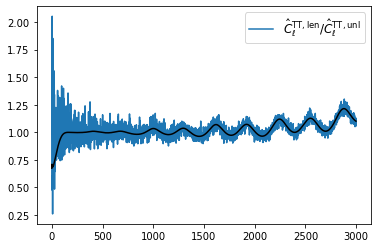

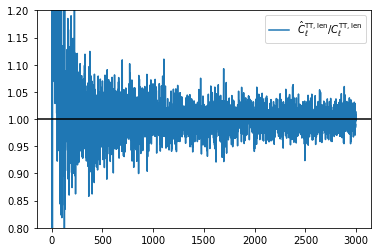

In [8]:
ell = np.arange(2, 3000 + 1, dtype=int)
cl_Tlen = hp.alm2cl(tlm_len)
pl.plot(ell, cl_Tlen[ell] /hp.alm2cl(tlm_unl)[ell], 
        label=r'$\hat C_\ell^{\rm TT, len}/\hat C_\ell^{\rm TT, unl}$')
pl.legend(fontsize=12)
pl.plot(cmb.cl_len['tt'][ell] /cmb.cl_unl['tt'][ell], c='k', label='Prediction')


pl.figure()
pl.plot(ell, cl_Tlen[ell] /cmb.cl_len['tt'][ell], 
        label=r'$\hat C_\ell^{\rm TT, len}/ C_\ell^{\rm TT, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend()

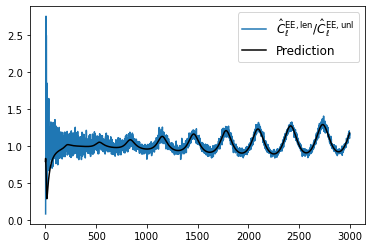

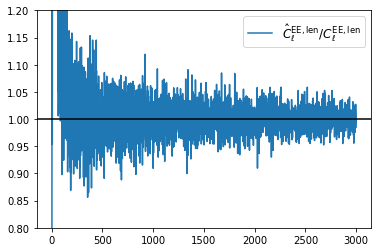

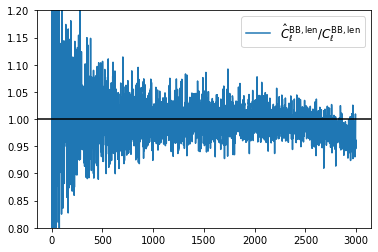

In [9]:
ell = np.arange(2, 3000 + 1, dtype=int)
pl.plot(ell, hp.alm2cl(elm_len)[ell] /hp.alm2cl(elm_unl)[ell], label=r'$\hat C_\ell^{\rm EE, len}/\hat C_\ell^{\rm EE, unl}$')
pl.plot(cmb.cl_len['ee'][ell] /cmb.cl_unl['ee'][ell], c='k', label='Prediction')
pl.legend(fontsize=12)

pl.figure()
pl.plot(ell, hp.alm2cl(elm_len)[ell] /cmb.cl_len['ee'][ell], label=r'$\hat C_\ell^{\rm EE, len}/ C_\ell^{\rm EE, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend(fontsize=12)

pl.figure()
pl.plot(ell, hp.alm2cl(blm_len)[ell] /cmb.cl_len['bb'][ell], label=r'$\hat C_\ell^{\rm BB, len}/ C_\ell^{\rm BB, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend(fontsize=12)

In [3]:
path = "/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps"

In [4]:
mass_path = os.path.join(path,'MASS')

In [5]:
cmb_path = os.path.join(path,'CMB')

In [6]:
beam = np.radians(.5)

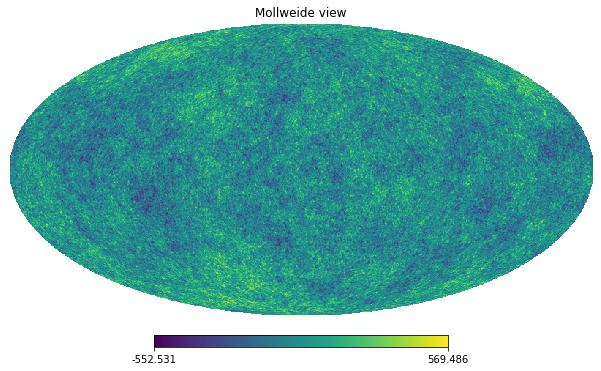

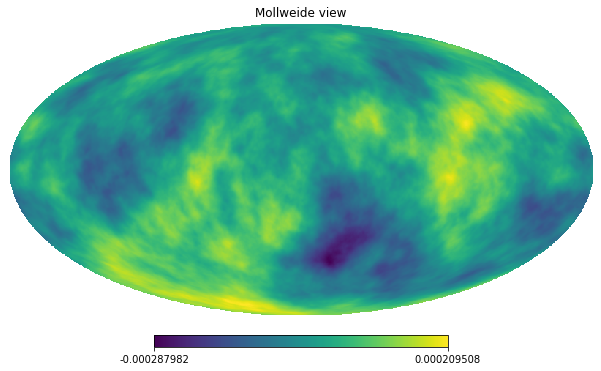

In [7]:
idx = 0 
cmb_map = hp.read_map(os.path.join(cmb_path,f'cmb_sims_{idx:04d}.fits'),dtype=np.float64)
hp.mollview(cmb_map)
phi_alm = hp.read_alm(os.path.join(mass_path,f'phi_sims_{idx:04d}.fits'))
phi_map = hp.alm2map(phi_alm,nside=2048)
hp.mollview(phi_map)

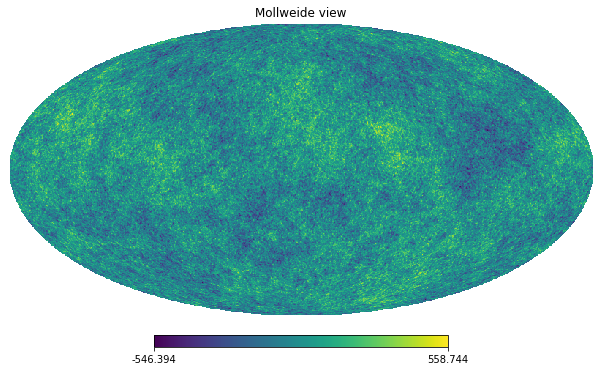

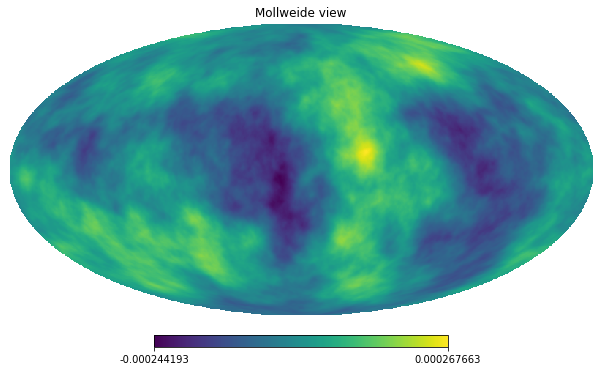

In [8]:
idx = 888
cmb_map = hp.read_map(os.path.join(cmb_path,f'cmb_sims_{idx:04d}.fits'),dtype=np.float64)
hp.mollview(cmb_map)
phi_alm = hp.read_alm(os.path.join(mass_path,f'phi_sims_{idx:04d}.fits'))
phi_map = hp.alm2map(phi_alm,nside=2048)
hp.mollview(phi_map)

In [9]:
seeds = pk.load(open(os.path.join(path,'seeds.pkl'),'rb'))

In [10]:
for x in seeds: 
    if seeds.count(x) > 1:
        print(f"seed {x} : {seeds.count(x)}")

In [11]:
len(seeds)

1000

In [12]:
seeds

[35355,
 26336,
 52086,
 81011,
 84947,
 75825,
 67901,
 96195,
 38812,
 30780,
 46093,
 87215,
 72478,
 94383,
 83502,
 21487,
 53046,
 92631,
 42693,
 89718,
 35425,
 94860,
 14581,
 97468,
 98501,
 41860,
 83819,
 71884,
 74361,
 63320,
 57177,
 69279,
 73754,
 68648,
 66382,
 68908,
 75186,
 54796,
 51883,
 91731,
 96056,
 99265,
 79305,
 13842,
 46829,
 56557,
 46708,
 77508,
 52903,
 59427,
 53994,
 92843,
 52868,
 11629,
 67336,
 18603,
 69233,
 54586,
 63193,
 66023,
 85887,
 30460,
 15838,
 74792,
 57294,
 95118,
 35883,
 69768,
 26429,
 80783,
 68463,
 88759,
 33681,
 21818,
 96019,
 27800,
 59746,
 31116,
 44342,
 69530,
 82609,
 57540,
 24129,
 65852,
 71972,
 72749,
 46224,
 71343,
 28916,
 41225,
 39985,
 34413,
 35624,
 72557,
 11701,
 69670,
 72598,
 17435,
 29052,
 30630,
 80416,
 27898,
 37785,
 92182,
 78487,
 85924,
 84151,
 98710,
 73593,
 80027,
 63059,
 81260,
 94871,
 72290,
 28644,
 36574,
 77132,
 50816,
 56613,
 62986,
 14743,
 99954,
 39513,
 66628,
 16556,
